In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, learning_curve

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_id = train["PassengerId"]
test_id = test["PassengerId"]

combined = pd.concat([train, test]).reset_index(drop=True)

# EDA

### Data Imbalance Check

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


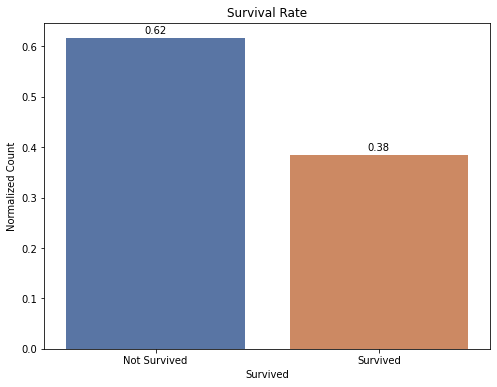

In [5]:
survived_counts = train["Survived"].value_counts(normalize=True)


plt.figure(figsize=(8, 6))
ax = sns.barplot(x=survived_counts.index, y=survived_counts.values)


sns.barplot(x=survived_counts.index, y=survived_counts.values, ax=ax, palette="deep")
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, padding=3, fmt='%.2f')

plt.title("Survival Rate")
plt.xlabel("Survived")
plt.ylabel("Normalized Count")
plt.xticks(ticks=[0, 1], labels=["Not Survived", "Survived"])  
plt.show()


### Sex Feature

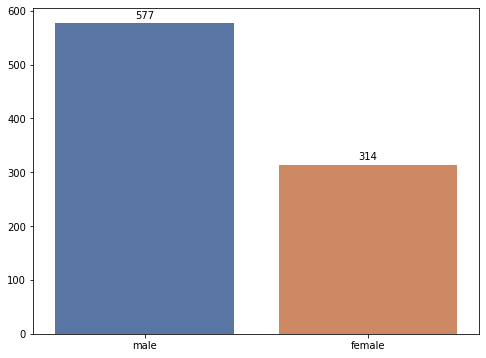

In [6]:
count = train["Sex"].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=train, x=count.index, y=count.values, palette="deep")
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, padding=3)

plt.show()

In [7]:
sex = train.groupby(["Sex"])[["Survived"]].value_counts(normalize=True)
sex

Sex     Survived
female  1           0.742038
        0           0.257962
male    0           0.811092
        1           0.188908
dtype: float64

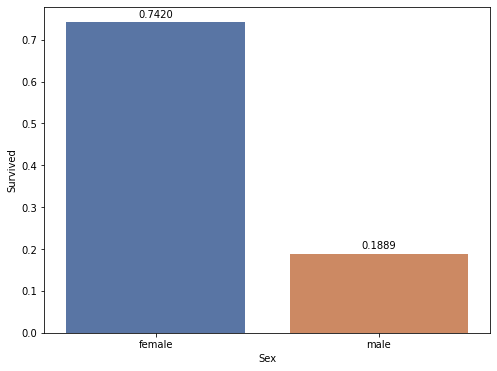

In [8]:
sex_survived = train.groupby(["Sex"])[["Survived"]].mean().reset_index()
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=sex_survived, x="Sex", y="Survived", palette="deep")
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, padding=3,fmt='%.4f')
plt.show()

The number of males is much higher than the females, but it turns out that the rate of females being survived is much higher than males. The females have a much higher survival rate (74%) than males (19%), around a 25.46% difference.

### Pclass Feature

In [9]:
train.groupby(["Pclass"])[["Survived"]].value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
dtype: int64

In [10]:
train.groupby(["Pclass"])[["Survived"]].value_counts(normalize=True)

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
dtype: float64

In [11]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

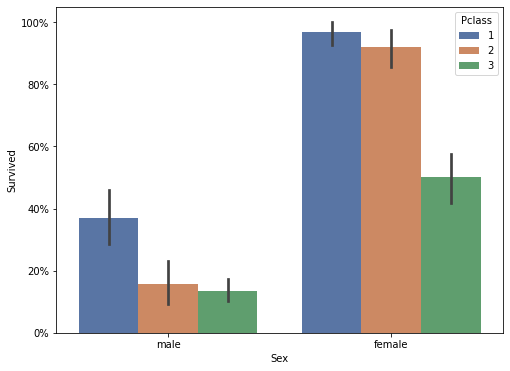

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=train, x="Sex", y="Survived", hue="Pclass", palette="deep")
ax.set_yticklabels(['{:.0%}'.format(y) for y in ax.get_yticks()])
plt.show()

Based on the analysis of passenger classes (pcclas), it can be observed that the survival rate differs significantly among the different classes. Specifically, passengers in pcclas 1 had a notably higher survival rate compared to those in pcclas 3, despite pcclas 3 having a considerably larger number of passengers than pcclas 1.
For ratio survived pclass 1 is around 63% and pclass 2 is around 48% 

### Age Feature

In [13]:
train["Age"].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

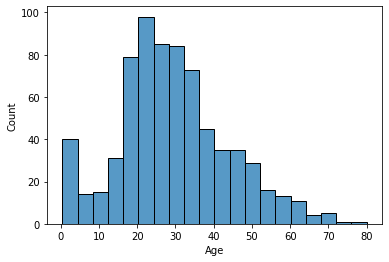

In [14]:
sns.histplot(train["Age"])
plt.show()

In [15]:
train.groupby(["Age"])[["Survived"]].mean().reset_index()

,Age,Survived
0,0.42,1.0
1,0.67,1.0
2,0.75,1.0
3,0.83,1.0
4,0.92,1.0
...,...,...
83,70.00,0.0
84,70.50,0.0
85,71.00,0.0
86,74.00,0.0


In [16]:
train_age = train.copy()
train_age.dropna(inplace=True)  

bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

train_age["Age"] = pd.cut(train_age["Age"], bins, labels=labels)

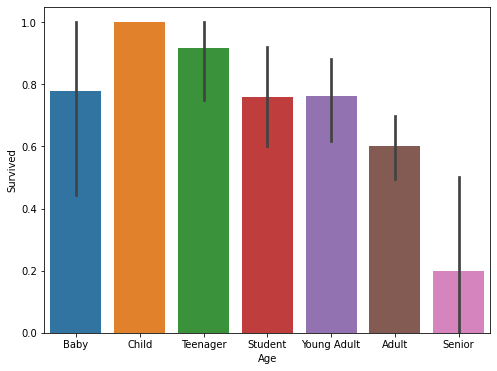

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(data=train_age, x="Age", y="Survived")
plt.show()

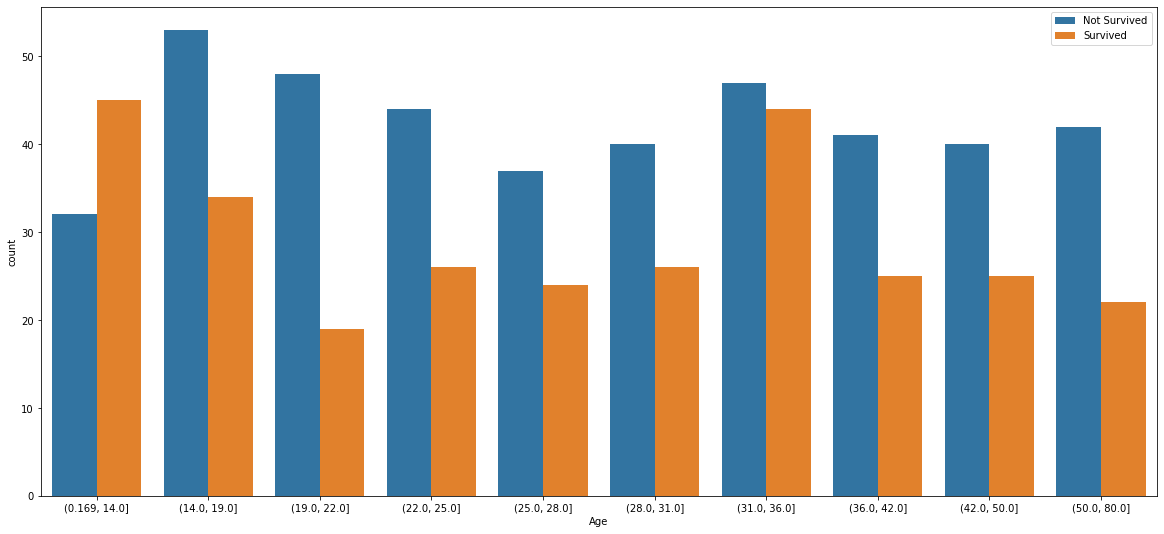

In [18]:
combined1 = combined.copy()
combined1['Age'] = pd.qcut(combined1['Age'], 10)
fig, axs = plt.subplots(figsize=(20, 9))
sns.countplot(x='Age', hue='Survived', data=combined1)

plt.legend(['Not Survived', 'Survived'])
plt.show()

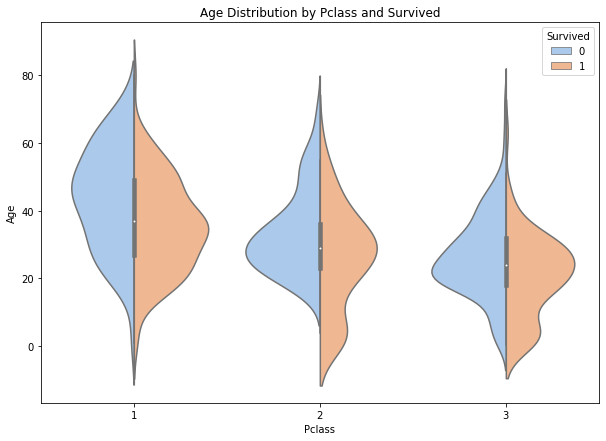

In [19]:
plt.figure(figsize=(10, 7))
sns.violinplot(data=train, x="Pclass", y="Age", hue="Survived", palette="pastel", split=True)
plt.title("Age Distribution by Pclass and Survived")
plt.xlabel("Pclass")
plt.ylabel("Age")
plt.show()

From the analysis above we can see some insights:

    • The age distribution is quite right skewed, with most passengers in their early to mid 20s. There are very few elderly      passengers
    • Children have a higher survival rate than adults. The survival rate decreases as age increases.
    • First bin with 10 quantiles has the higher survival rate, and 4th bin has the lowest survival rate.
    • Passengers in Pclass 1 tend to be older than Pclass 2 and 3. Pclass 1 passengers also have higher survival rates across most age groups than Pclass 2 and 3.



## Fare

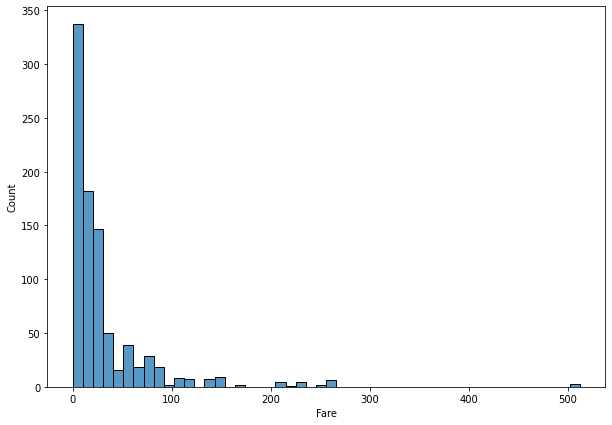

In [20]:
plt.figure(figsize=(10, 7))
sns.histplot(train["Fare"], bins=50)
plt.show()

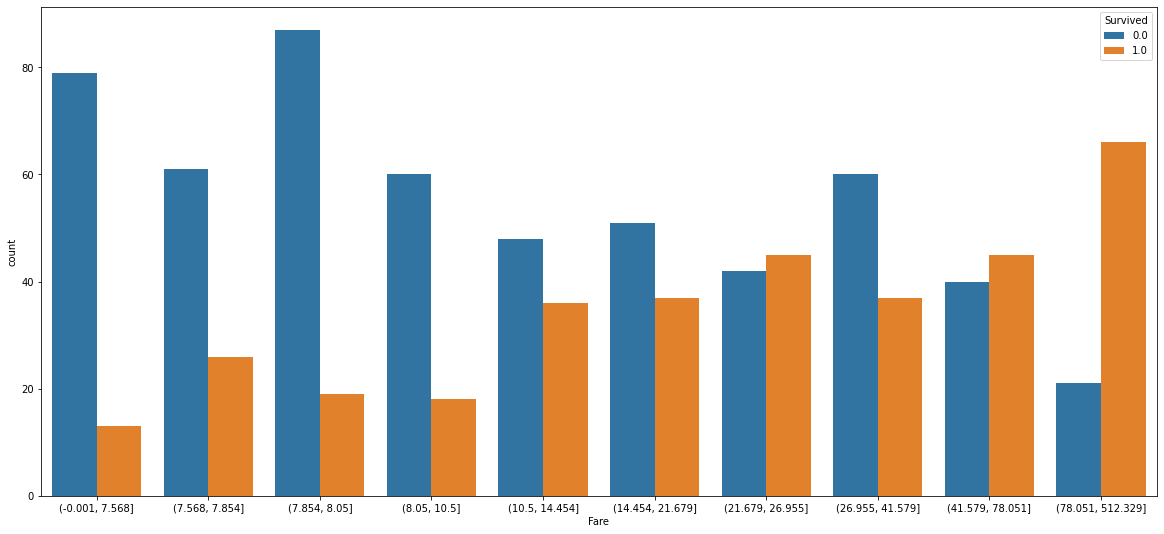

In [21]:
combined1 = combined.copy()
combined1['Fare'] = pd.qcut(combined1['Fare'], 10)
fig, axs = plt.subplots(figsize=(20, 9))
sns.countplot(x='Fare', hue='Survived', data=combined1)

plt.show()

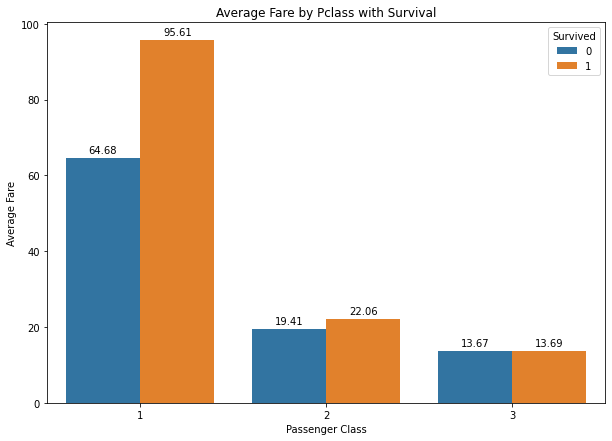

In [22]:
data_fare = train.groupby(["Pclass", "Survived"])[["Fare"]].mean().reset_index()

plt.figure(figsize=(10, 7))
ax= sns.barplot(x="Pclass", y="Fare", hue="Survived", data=data_fare)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, padding=3,fmt='%.2f')
ax.bar_label(ax.containers[1], label_type='edge', fontsize=10, padding=3,fmt='%.2f')
plt.title("Average Fare by Pclass with Survival")
plt.xlabel("Passenger Class")
plt.ylabel("Average Fare")
plt.show()

There is a clear trend of higher survival rates for higher fare values. Passengers paying over 100 fare had survival rates above 50%. This makes sense as higher fare correlated to higher classes which had better access to lifeboats. 

## Embarked

In [23]:
train.groupby(["Embarked"])[["Fare"]].mean().reset_index()

,Embarked,Fare
0,C,59.954144
1,Q,13.276030
2,S,27.079812


In [24]:
train.groupby(["Embarked"])[["Survived"]].mean().reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [25]:
(pd.crosstab([train["Embarked"],train["Pclass"]],
             [train["Sex"],train["Survived"]],margins=True).style.background_gradient(cmap='Pastel1'))

Looking at the crosstab between Embarked, Pclass, Sex and Survived: 

    • For all embarkation ports, women had much higher survival rates than men across all passenger classes.
    • In general, survival decreased with lower passenger class, but women still had relatively high survival rates even in 3rd  class.
    • Southampton showed the greatest decrease in survival between the highest and lowest classes (55% to 15%), the single largest drop of 43 percentage points occurred at Cherbourg, going from Pclass 1 to Pclass 2.

# Feature Engineering

## Add Aditional Data

In [26]:
combined["family"] = combined["Parch"] + combined["SibSp"]+1
combined["singlef"] = combined["family"].map(lambda i: 1 if i ==1 else 0)
#combined["smallf"] = combined["family"].map(lambda i: 1 if i == 2 else 0)
#combined["mediumf"] = combined["family"].map(lambda i: 1 if 3 <= i <= 4 else 0)
#combined["largef"] = combined["family"].map(lambda i: 1 if i >= 5 else 0)

In [27]:
#combined['Fare_Per_Person']=combined['Fare']/(combined['family']+1)

In [28]:
combined["CabinBool"] = (combined["Cabin"].notnull().astype('int'))

family survival rate increase pretty much my score and the below code is actually i found from the ....., i have worked my own family survival rate but turns out not really increase as much as the .... code.

In [29]:
def family_survival():
    global combined

    ''' A function working on family survival rate using last names and ticket features: '''

    # Extracting surnames:
    
    combined['Last_Name'] = combined['Name'].apply(
        lambda x: str.split(x, ",")[0])

    # Adding new feature: 'Survived'
    
    default_survival_rate = 0.5
    combined['Family_Survival'] = default_survival_rate

    for grp, grp_df in combined[[
            'Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
            'SibSp', 'Parch', 'Age', 'Cabin'
    ]].groupby(['Last_Name', 'Fare']):

        if (len(grp_df) != 1):
            
            # A Family group is found.
            
            for ind, row in grp_df.iterrows():
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    combined.loc[combined['PassengerId'] ==
                                 passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    combined.loc[combined['PassengerId'] ==
                                 passID, 'Family_Survival'] = 0

    for _, grp_df in combined.groupby('Ticket'):
        if (len(grp_df) != 1):
            for ind, row in grp_df.iterrows():
                if (row['Family_Survival'] == 0) | (
                        row['Family_Survival'] == 0.5):
                    smax = grp_df.drop(ind)['Survived'].max()
                    smin = grp_df.drop(ind)['Survived'].min()
                    passID = row['PassengerId']
                    if (smax == 1.0):
                        combined.loc[combined['PassengerId'] ==
                                     passID, 'Family_Survival'] = 1
                    elif (smin == 0.0):
                        combined.loc[combined['PassengerId'] ==
                                     passID, 'Family_Survival'] = 0

    return combined    

In [30]:
combined = family_survival()

In [31]:
combined.drop(["PassengerId", "Last_Name"], axis=1, inplace=True)

In [32]:
"""
def family_survival(combined):
    ''' A function working on family survival rate using last names and ticket features. '''

    # Extracting surnames:
    last_names = []
    for i in combined["Name"]:
        i_str = str(i)
        name_parts = i_str.split(",")[0]
        last_names.append(name_parts)

    combined["last_name"] = pd.Series(last_names)

    # Calculate family survival rate based on last name and ticket features:
    default_survival_rate = 0.5
    combined['Family_Survival'] = default_survival_rate

    for grp, grp_df in combined[[
        'Survived', 'Name', 'last_name', 'Fare', 'Ticket', 'PassengerId',
        'SibSp', 'Parch', 'Age', 'Cabin'
    ]].groupby(['last_name', 'Fare']):

        if len(grp_df) > 1:
            for ind, row in grp_df.iterrows():
                # Find the maximum and minimum survival values for the family
                smax = grp_df['Survived'].max()
                smin = grp_df['Survived'].min()
                passID = row['PassengerId']

                # Assign family survival rate to 'Family_Survival' column for each family member
                if smax == 1.0:
                    combined.loc[combined['PassengerId'] == passID, 'Family_Survival'] = 1
                elif smin == 0.0:
                    combined.loc[combined['PassengerId'] == passID, 'Family_Survival'] = 0

    # After calculating family survival rates, process group by 'Ticket'
    for _, grp_df in combined.groupby('Ticket'):
        if len(grp_df) != 1:
            for ind, row in grp_df.iterrows():
                if len(combined.loc[combined['PassengerId'] == row['PassengerId'], 'Family_Survival']) == 0:
                    if (grp_df['Family_Survival'].mean() != 0.0) & (grp_df['Family_Survival'].mean() != 1.0):
                        combined.loc[combined['PassengerId'] == row['PassengerId'], 'Family_Survival'] = grp_df['Family_Survival'].mean()

    # Drop the temporary 'last_name' column as it's no longer needed
    combined.drop(columns=['last_name'], inplace=True)

    return combined

# Call the function and assign the modified DataFrame to the 'combined' variable
combined = family_survival(combined)
    """

'\ndef family_survival(combined):\n    \'\'\' A function working on family survival rate using last names and ticket features. \'\'\'\n\n    # Extracting surnames:\n    last_names = []\n    for i in combined["Name"]:\n        i_str = str(i)\n        name_parts = i_str.split(",")[0]\n        last_names.append(name_parts)\n\n    combined["last_name"] = pd.Series(last_names)\n\n    # Calculate family survival rate based on last name and ticket features:\n    default_survival_rate = 0.5\n    combined[\'Family_Survival\'] = default_survival_rate\n\n    for grp, grp_df in combined[[\n        \'Survived\', \'Name\', \'last_name\', \'Fare\', \'Ticket\', \'PassengerId\',\n        \'SibSp\', \'Parch\', \'Age\', \'Cabin\'\n    ]].groupby([\'last_name\', \'Fare\']):\n\n        if len(grp_df) > 1:\n            for ind, row in grp_df.iterrows():\n                # Find the maximum and minimum survival values for the family\n                smax = grp_df[\'Survived\'].max()\n                smin = gr

## Feature Transformation

In [33]:
title_dictionary = {
        'Capt': 'Mr',
        'Col': 'Other',
        'Major': 'Mr',
        'Jonkheer': 'Other',
        'Don': 'Mr',
        'Dona': 'Mrs',
        'Sir': 'Mr',
        'Dr': 'Mr',
        'Rev': 'Other',
        'the Countess': 'Mrs',
        'Mme': 'Miss',
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Mr': 'Mr',
        'Mrs': 'Mrs',
        'Miss': 'Miss',
        'Master': 'Master',
        'Lady': 'Mrs'
    }
    
combined["title"] = combined["Name"].map(lambda i: i.split(',')[1].split(".")[0].strip())
combined["title"] = combined["title"].map(title_dictionary)
combined.drop("Name", axis=1, inplace=True)

## Filling the Missing Values

### Age


To fill in the missing age values, I decided to use the mean of titles and ages instead of the median, as the scores increased slightly

In [34]:
combined.groupby(["title"])[["Age"]].mean().reset_index()

,title,Age
0,Master,5.482642
1,Miss,21.834533
2,Mr,32.545531
3,Mrs,37.046243
4,Other,44.923077


In [35]:
"""
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Mr"), "Age"] = 30
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Mrs"), "Age"] = 36
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Master"), "Age"] = 4
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Miss"), "Age"] = 22
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Other"), "Age"] = 47
    """

'\ncombined.loc[(combined["Age"].isnull()) & (combined["title"]=="Mr"), "Age"] = 30\ncombined.loc[(combined["Age"].isnull()) & (combined["title"]=="Mrs"), "Age"] = 36\ncombined.loc[(combined["Age"].isnull()) & (combined["title"]=="Master"), "Age"] = 4\ncombined.loc[(combined["Age"].isnull()) & (combined["title"]=="Miss"), "Age"] = 22\ncombined.loc[(combined["Age"].isnull()) & (combined["title"]=="Other"), "Age"] = 47\n    '

In [36]:
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Mr"), "Age"] = 33
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Mrs"), "Age"] = 37
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Master"), "Age"] = 5
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Miss"), "Age"] = 22
combined.loc[(combined["Age"].isnull()) & (combined["title"]=="Other"), "Age"] = 45

### Age Group

I made an age categorization using the silhouette method and the results are pretty good

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


data = combined["Age"].values.reshape(-1, 1)

# Define the range of cluster numbers you want to try
min_clusters = 2
max_clusters = 8

# Create a list to store the cluster labels for different configurations
sil = []

# Iterate through different cluster numbers
for i in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=i).fit(data)
    labels = kmeans.labels_
   
    sil.append(silhouette_score(data, labels, metric = 'euclidean'))
plt_data=pd.concat([pd.Series(range(2,9)),pd.Series(sil)],axis=1)
   
    


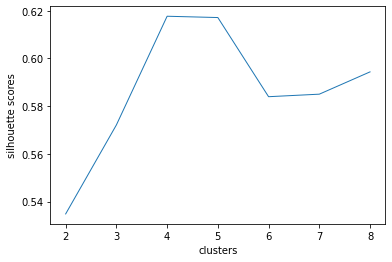

In [38]:
plt_data.rename( columns={ 0 :'clusters' , 1 :'silhouette scores'}, inplace=True )
   
ax = sns.lineplot(x="clusters", y="silhouette scores",
                       estimator=None, lw=1,
                       err_style="bars", ci=68, 
                       data=plt_data)

In [39]:
data = combined["Age"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=5, random_state=0).fit(data)
labels = kmeans.labels_

data_df = pd.DataFrame(data, columns=['Age'])

data_df['age_grp'] = labels + 1

In [40]:
combined["age_grp"] = data_df["age_grp"]

In [41]:
age_bins = pd.get_dummies(combined["age_grp"], prefix="age_grp")

In [42]:
combined = pd.concat([combined, age_bins], axis=1)
combined.drop('age_grp', inplace=True, axis=1)
combined.drop('Age', inplace=True, axis=1)

### Embarked 

In [43]:
combined['Embarked'].fillna('C', inplace = True)

There's 2 missing values on Embarked, and both of these passengers have a fare amount of 80. Since 80 is closest to the mean fare for Cherbourg(you can see this on EDA process), it is a reasonable assumption that these two passengers with missing values likely embarked from Cherbourg. So i decided to fill these 2 missing values with embarked C

### Fare 

In [44]:
combined['Fare'] = combined.groupby(
        ['Pclass', 'Sex'])['Fare'].apply(lambda x: x.fillna(x.median()))

### Fare Normalization

In [45]:
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p
combined['Fare'] = boxcox1p(combined['Fare'],
                                boxcox_normmax(combined['Fare'] + 1))

### Fare Group

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = combined["Fare"].values.reshape(-1, 1)

sil = []
for  i in range(2, 9):
    kmeans = KMeans(n_clusters=i).fit(data)
    labels = kmeans.labels_
    sil.append(silhouette_score(data, labels, metric = 'euclidean'))
    
plt_data=pd.concat([pd.Series(range(2,9)),pd.Series(sil)],axis=1)

In [47]:
plt_data

,0,1
0,2,0.636513
1,3,0.621765
2,4,0.656917
3,5,0.652633
4,6,0.703430
5,7,0.694099
6,8,0.699437


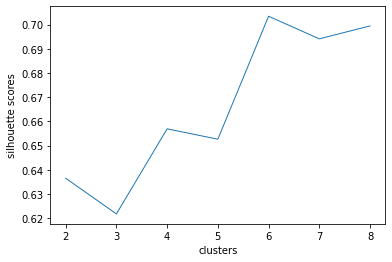

In [48]:
plt_data.rename( columns={ 0 :'clusters' , 1 :'silhouette scores'}, inplace=True )

ax = sns.lineplot(x="clusters", y="silhouette scores",
                       estimator=None, lw=1,
                       err_style="bars", ci=68, 
                       data=plt_data)

In [49]:
data = combined["Fare"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=6, random_state=0).fit(data)

labels = kmeans.labels_

data_df = pd.DataFrame(data, columns=['Fare'])

data_df['fare_grp'] = labels + 1

In [50]:
combined["fare_grp"] = data_df['fare_grp']

In [51]:
combined["fare_grp"].value_counts()

4    476
1    304
2    256
6    185
3     71
5     17
Name: fare_grp, dtype: int64

In [52]:
fare_encod = pd.get_dummies(combined["fare_grp"], prefix="fare_grp")
combined = pd.concat([fare_encod, combined], axis=1)
combined.drop("Fare",axis=1,inplace=True)

In [53]:
combined.drop(["fare_grp"],axis=1,inplace=True)

In [54]:
combined

,fare_grp_1,fare_grp_2,fare_grp_3,fare_grp_4,fare_grp_5,fare_grp_6,Survived,Pclass,Sex,SibSp,...,family,singlef,CabinBool,Family_Survival,title,age_grp_1,age_grp_2,age_grp_3,age_grp_4,age_grp_5
0,0,0,0,1,0,0,0.0,3,male,1,...,2,0,0,0.5,Mr,0,0,1,0,0
1,0,0,0,0,0,1,1.0,1,female,1,...,2,0,1,0.5,Mrs,0,1,0,0,0
2,0,0,0,1,0,0,1.0,3,female,0,...,1,1,0,0.5,Miss,0,0,1,0,0
3,0,0,0,0,0,1,1.0,1,female,1,...,2,0,1,0.0,Mrs,0,1,0,0,0
4,0,0,0,1,0,0,0.0,3,male,0,...,1,1,0,0.5,Mr,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,0,1,0,0,NaN,3,male,0,...,1,1,0,0.5,Mr,0,1,0,0,0
1305,0,0,0,0,0,1,NaN,1,female,0,...,1,1,1,1.0,Mrs,0,0,0,1,0
1306,0,0,0,1,0,0,NaN,3,male,0,...,1,1,0,0.5,Mr,0,0,0,1,0
1307,0,0,0,1,0,0,NaN,3,male,0,...,1,1,0,0.5,Mr,0,1,0,0,0


### Cabin

I decided to leave the cabin as i didn't see any increase in score, other than the hassle

In [55]:
#combined["Cabin"].fillna("N", inplace=True)

In [56]:
#combined.Cabin = [str(i)[0] for i in combined.Cabin]

In [57]:
"""
cabin_list = []
for i in combined["Cabin"]:
    cabin = str(i)
    cabin_list.append(cabin[0])
combined["Cabin"] = cabin_list
    """

'\ncabin_list = []\nfor i in combined["Cabin"]:\n    cabin = str(i)\n    cabin_list.append(cabin[0])\ncombined["Cabin"] = cabin_list\n    '

In [58]:
#combined.groupby("Cabin")['Fare'].mean().sort_values()

In [59]:
"""
def cabin_estimator(i):

    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

combined['Cabin'] = combined["Fare"].apply(lambda x: cabin_estimator(x))
 """

'\ndef cabin_estimator(i):\n\n    a = 0\n    if i<16:\n        a = "G"\n    elif i>=16 and i<27:\n        a = "F"\n    elif i>=27 and i<38:\n        a = "T"\n    elif i>=38 and i<47:\n        a = "A"\n    elif i>= 47 and i<53:\n        a = "E"\n    elif i>= 53 and i<54:\n        a = "D"\n    elif i>=54 and i<116:\n        a = \'C\'\n    else:\n        a = "B"\n    return a\n\ncombined[\'Cabin\'] = combined["Fare"].apply(lambda x: cabin_estimator(x))\n '

In [60]:
combined.drop("Cabin", axis=1, inplace=True)

### Ticket

the same reason as cabin, i decided to drop ticket

In [61]:
combined.drop("Ticket", axis=1, inplace=True)

### Title Encoder

In [62]:
title_encoder = pd.get_dummies(combined["title"], prefix="title")
combined = pd.concat([title_encoder, combined], axis=1)
combined.drop("title",axis=1,inplace=True)

### Embarked Encoder

In [63]:
Embarked_encoder = pd.get_dummies(combined["Embarked"], prefix="Embarked")
combined = pd.concat([Embarked_encoder, combined], axis=1)
combined.drop("Embarked",axis=1,inplace=True)

### Cabin Encoder

In [64]:
#cabin_encoder = pd.get_dummies(combined["Cabin"], prefix="Cabin")
#combined = pd.concat([cabin_encoder, combined], axis=1)
#combined.drop("Cabin",axis=1,inplace=True)

### Sex Encoder

In [65]:
combined["Sex"] = combined["Sex"].map({"male":1, "female":0})

### Pclass Encoder

In [66]:
#pclass_encoder = pd.get_dummies(combined["Pclass"], prefix="Pclass")
#combined = pd.concat([pclass_encoder, combined], axis=1)
#combined.drop("Pclass",axis=1,inplace=True)

In [67]:
combined

,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,fare_grp_1,fare_grp_2,...,Parch,family,singlef,CabinBool,Family_Survival,age_grp_1,age_grp_2,age_grp_3,age_grp_4,age_grp_5
0,0,0,1,0,0,1,0,0,0,0,...,0,2,0,0,0.5,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,2,0,1,0.5,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,1,1,0,0.5,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,2,0,1,0.0,0,1,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,1,0,0,0
1305,1,0,0,0,0,0,1,0,0,0,...,0,1,1,1,1.0,0,0,0,1,0
1306,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,0,0,1,0
1307,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,1,0,0,0


# Modeling

In [68]:
idx = len(train)

In [69]:
combined.drop("Survived", axis=1, inplace=True)

In [70]:
x_train = combined.iloc[:idx].copy()
x_test = combined.iloc[idx:].copy()

y = train["Survived"]

In [71]:
print(f"{x_train.shape}, {x_test.shape}, {y.shape}")

(891, 27), (418, 27), (891,)


In [72]:
combined

,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,fare_grp_1,fare_grp_2,...,Parch,family,singlef,CabinBool,Family_Survival,age_grp_1,age_grp_2,age_grp_3,age_grp_4,age_grp_5
0,0,0,1,0,0,1,0,0,0,0,...,0,2,0,0,0.5,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,2,0,1,0.5,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,1,1,0,0.5,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,2,0,1,0.0,0,1,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,1,0,0,0
1305,1,0,0,0,0,0,1,0,0,0,...,0,1,1,1,1.0,0,0,0,1,0
1306,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,0,0,1,0
1307,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0.5,0,1,0,0,0


## Hyperparamater Tunning

In [73]:
"""
def objective(trial):
    rf_param_space = {
     'n_estimators' : trial.suggest_int('n_estimators', 1000, 3000),
    'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'max_depth' : trial.suggest_int('max_depth', 5, 15),
    'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
    'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt']),
    'oob_score': trial.suggest_categorical('oob_score', [True, False]),
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 0
}  
    model = RandomForestClassifier(**rf_param_space)
    kfold = StratifiedKFold(10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, x_train, y, cv=kfold)
    accuracy = cv_scores.mean()

    return accuracy

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=200)

best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)
    """

'\ndef objective(trial):\n    rf_param_space = {\n     \'n_estimators\' : trial.suggest_int(\'n_estimators\', 1000, 3000),\n    \'criterion\' : trial.suggest_categorical(\'criterion\', [\'gini\', \'entropy\']),\n    \'max_depth\' : trial.suggest_int(\'max_depth\', 5, 15),\n    \'min_samples_split\' : trial.suggest_int(\'min_samples_split\', 2, 10),\n    \'min_samples_leaf\' : trial.suggest_int(\'min_samples_leaf\', 1, 10),\n    \'max_features\' : trial.suggest_categorical(\'max_features\', [\'auto\', \'sqrt\']),\n    \'oob_score\': trial.suggest_categorical(\'oob_score\', [True, False]),\n    \'random_state\': 42,\n    \'n_jobs\': -1,\n    \'verbose\': 0\n}  \n    model = RandomForestClassifier(**rf_param_space)\n    kfold = StratifiedKFold(10, shuffle=True, random_state=42)\n    cv_scores = cross_val_score(model, x_train, y, cv=kfold)\n    accuracy = cv_scores.mean()\n\n    return accuracy\n\nstudy = optuna.create_study(direction="maximize")  \nstudy.optimize(objective, n_trials=200)\

In [74]:
"""
def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [20, 50, 100, 250, 500, 1000,2000,3000]),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
       'max_depth': trial.suggest_int('max_depth', 2, 25),
       'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
       'subsample': trial.suggest_float('subsample', 0.1, 1.0),
       'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
        'gamma': trial.suggest_categorical('gamma', [0, 0.001, 0.01, 0.1, 1, 10, 100]),
       'min_child_weight': trial.suggest_categorical('min_child_weight', [0.01, 0.1, 1, 10, 100]),
        'random_state': 42,
        'n_jobs': -1
        
         
        
        
    }

    model =  XGBClassifier(**xgb_params)
    kfold = StratifiedKFold(n_splits=10)
    cv_scores = cross_val_score(model, x_train, y, cv=kfold)
    accuracy = cv_scores.mean()

    return accuracy

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=250)

best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)
    """

'\ndef objective(trial):\n    xgb_params = {\n        \'n_estimators\': trial.suggest_categorical(\'n_estimators\', [20, 50, 100, 250, 500, 1000,2000,3000]),\n      \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.1, 1.0),\n       \'max_depth\': trial.suggest_int(\'max_depth\', 2, 25),\n       \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0, 1.0),\n       \'subsample\': trial.suggest_float(\'subsample\', 0.1, 1.0),\n       \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.001, 1.0),\n        \'gamma\': trial.suggest_categorical(\'gamma\', [0, 0.001, 0.01, 0.1, 1, 10, 100]),\n       \'min_child_weight\': trial.suggest_categorical(\'min_child_weight\', [0.01, 0.1, 1, 10, 100]),\n        \'random_state\': 42,\n        \'n_jobs\': -1\n        \n         \n        \n        \n    }\n\n    model =  XGBClassifier(**xgb_params)\n    kfold = StratifiedKFold(n_splits=10)\n    cv_scores = cross_val_score(model, x_train, y, cv=kfold)\n    accuracy = cv_scores.mean(

## Model Selection

In [80]:
cv = StratifiedKFold(10, shuffle=True, random_state=42)

rf = RandomForestClassifier(criterion='gini',
                            n_estimators=1750,
                            max_depth=7,
                            min_samples_split=6,
                            min_samples_leaf=6,
                            max_features='auto',
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1,
                            verbose=0
                           )



lg = LGBMClassifier(max_bin=4,
                        num_iterations=550,
                        learning_rate=0.0114,
                        max_depth=3,
                        num_leaves=7,
                        colsample_bytree=0.35,
                        random_state=42,
                        n_jobs=-1)

xg = XGBClassifier(
    n_estimators=2800,
    min_child_weight=0.1,
    learning_rate=0.002,
     max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.4,
    random_state=42,
    n_jobs=-1,
    
    
    
)

sv = SVC(probability=True)

logreg = LogisticRegression(n_jobs=-1, solver='newton-cg')

gb = GradientBoostingClassifier(random_state=42)

gnb = GaussianNB()

mlp = MLPClassifier(random_state=42)

In [83]:
model_list = [
   rf, lg,xg,sv,logreg,gb,gnb,mlp
]

train_accuracies = []
test_accuracies = []

for model in model_list:
    cv_results = cross_validate(model, x_train, y, cv=cv,  scoring='accuracy', return_train_score=True, n_jobs=-1)
    
    train_accuracy_mean = np.mean(cv_results['train_score'])
    test_accuracy_mean = np.mean(cv_results['test_score'])
    
    train_accuracies.append(train_accuracy_mean)
    test_accuracies.append(test_accuracy_mean)

cv_res = pd.DataFrame({"Model":[              
"RandomForestClassifier", "LGBMClassifier", "XGBClassifier", "SVC", 
    "LogisticRegression", "GradientBoosting", "GaussianNB", "MLPClassifier"], 
                       "Train Score": train_accuracies, "Test Score": test_accuracies })

cv_res

,Model,Train Score,Test Score
0,RandomForestClassifier,0.857837,0.843983
1,LGBMClassifier,0.862451,0.848452
2,XGBClassifier,0.859708,0.848464
3,SVC,0.836139,0.830499
4,LogisticRegression,0.853722,0.847316
5,GradientBoosting,0.883776,0.845094
6,GaussianNB,0.755834,0.755306
7,MLPClassifier,0.857712,0.832734


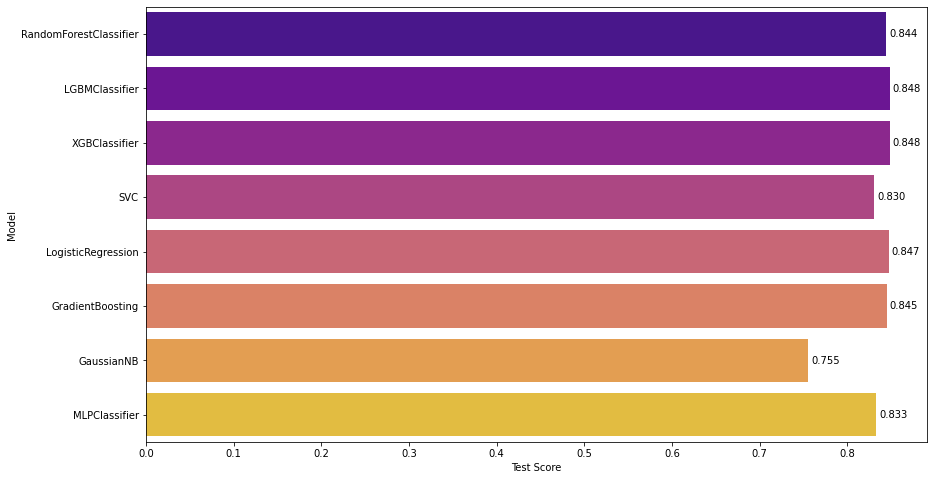

In [84]:
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.barplot(data=cv_res, y="Model", x="Test Score",  palette='plasma',
                    orient='h',)

ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, padding=3,fmt='%.3f')
plt.show()

## Learning Curve

In [85]:
def learning_curve_plot(model,model_name, x_train, y):
    training_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=x_train, y=y, cv=5,
                   n_jobs=-1, train_sizes=training_sizes, )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    f, ax = plt.subplots( figsize=(10, 8))  # Adjust figsize to your preference
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    ax.set_xlabel('Number of Training Samples')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Learning Curve - {model_name}')
    ax.legend(loc='best')
    ax.grid()

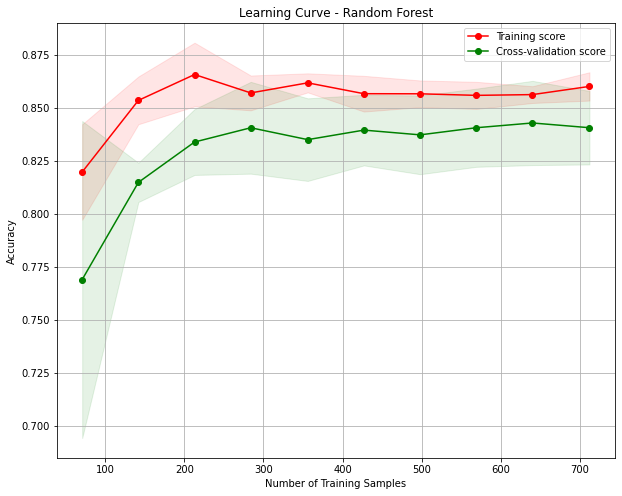

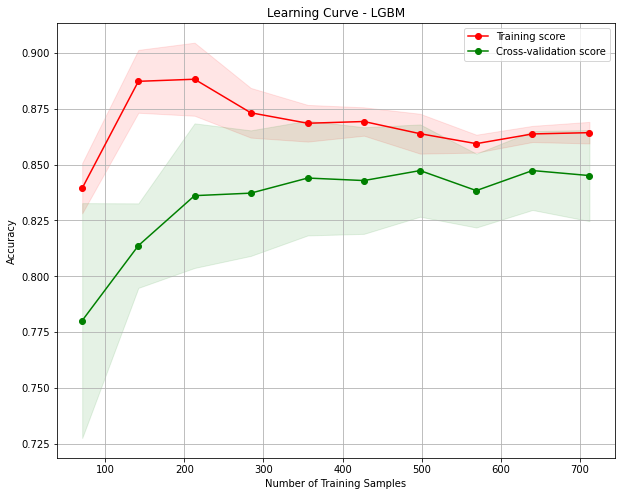

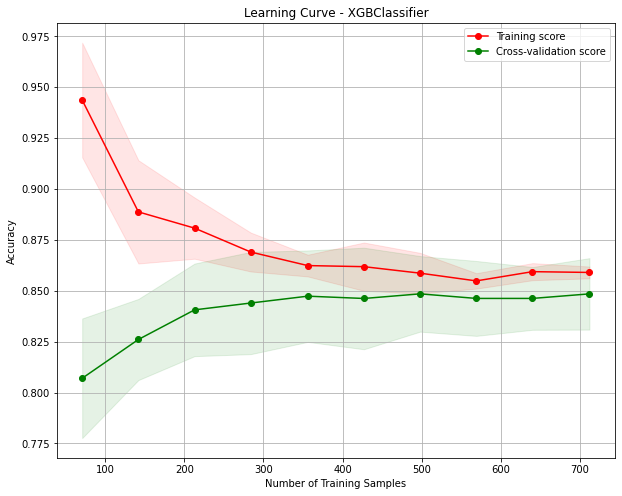

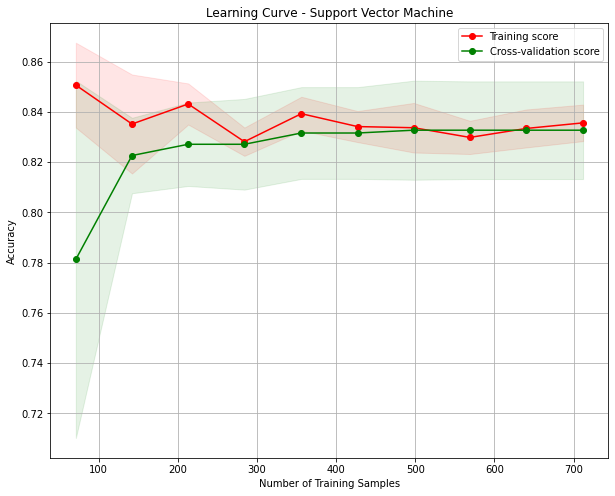

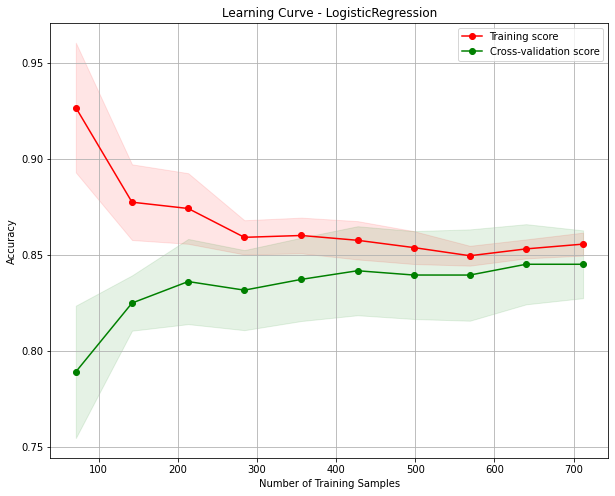

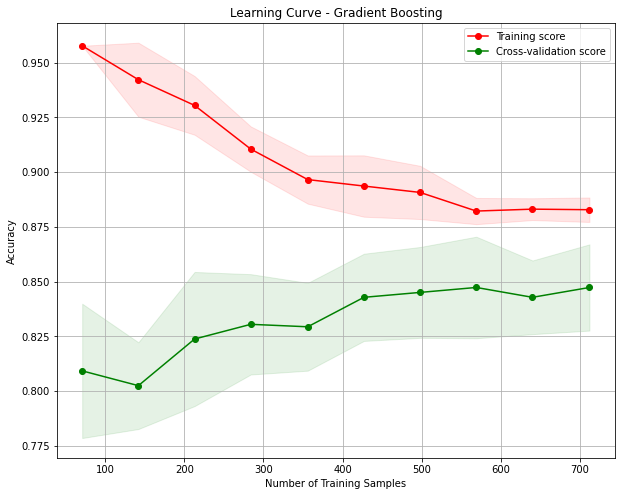

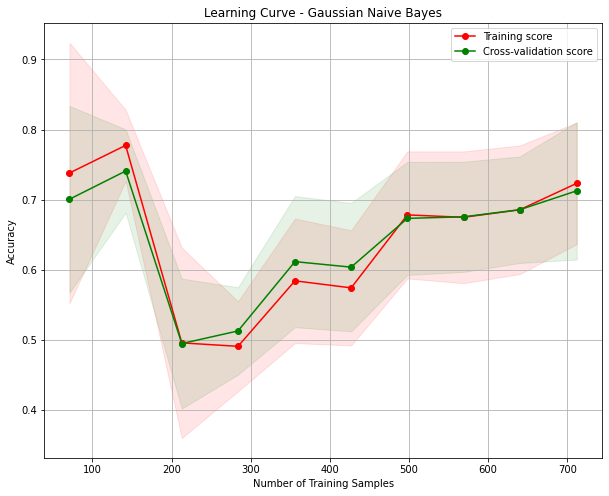

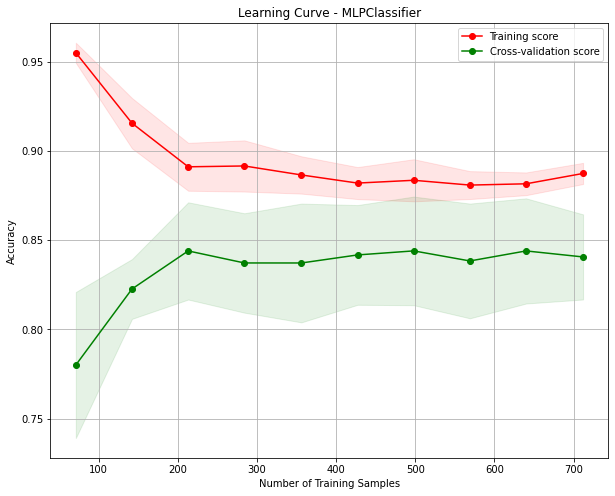

In [88]:
model_names = [
    "Random Forest",
    "LGBM",
     "XGBClassifier",
     "Support Vector Machine",
     "LogisticRegression",
     "Gradient Boosting",
     "Gaussian Naive Bayes",
     "MLPClassifier"
]

for model, model_name in zip(model_list, model_names):
    learning_curve_plot(model, model_name, x_train, y)

## Ensembling

After some trial and error of conflating which model should I use in this ensemble method, I finally settled on XGBoost and RandomForest, because the combination of the two models can achieve a higher score

In [89]:
from sklearn.ensemble import VotingClassifier

In [90]:
classifier = VotingClassifier(estimators=[('XGB', xg), ('RandomForest', rf)],  voting='soft')

"""model evaluation"""
cv = StratifiedKFold(5, shuffle=True, random_state=42)
accuracies = cross_val_score(classifier, x_train , y , cv = cv)
print("5 fold cross validation accuracies {}".format(accuracies))
print(f"mean cross validation accuracies {accuracies.mean()}")

5 fold cross validation accuracies [0.8547486  0.8258427  0.83146067 0.85955056 0.87078652]
mean cross validation accuracies 0.8484778105580316


# Submission


I ended up submitting predictions using the random forest model because it had a pretty high score than both the ensemble and the xgb

In [91]:
rand_model_full_data = rf.fit(x_train, y)
cv = StratifiedKFold(10, shuffle=True, random_state=42)
cv_score = cross_val_score(rand_model_full_data, x_train , y , cv = cv)
print(cv_score.mean())

0.8439825218476903


In [92]:
xgb = xg.fit(x_train, y)
cv = StratifiedKFold(5, shuffle=True, random_state=42)
cv_score = cross_val_score(xgb, x_train , y , cv = cv)
print(cv_score.mean())

0.8507250015692674


In [ ]:
#classifier.fit(x_train, y)
#ensemble = classifier.predict(x_test)

In [ ]:
#xg_predict = xg.predict(x_test)

In [93]:
rf_predict = rf.predict(x_test)

In [95]:
output = pd.DataFrame({ 'PassengerId' : test_id, 'Survived': rf_predict })
output.to_csv('mysubmission.csv', index=False)